# Result


<img  src="./img/results.PNG" width="50%">

In [0]:
!pip install sklearn_crfsuite
!sudo pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install seqeval

!pip uninstall keras
!pip install keras==2.2.4

In [0]:
!python -c 'import keras; print(keras.__version__)'
## needs to be 2.2.4

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from itertools import chain
import gc
from time import time

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
# from sklearn.cross_validation import cross_val_score
# from sklearn.grid_search import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
from keras.utils import to_categorical
from keras_contrib.layers import CRF
from keras import backend as K
import tensorflow as tf

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score

results = []


Using TensorFlow backend.


In [0]:
!dir data

dir: cannot access 'data': No such file or directory


# 1. Conditional Random Field


In [0]:
os.chdir('/gdrive/My Drive/estsoft')

#train_CoNLL03_sample = open('./data/train.txt')
train_CoNLL03_sample = open('./data/train_full.txt')
train = [line for line in train_CoNLL03_sample]

dev_CoNLL03_sample = open('./data/dev.txt')
dev = [line for line in dev_CoNLL03_sample]

def change_form(f):
    form = []
    temp = []
    for line in f:
        if len(line)==0 or line[0]=="\n":
            if len(temp) > 0:
                form.append(temp)
                temp = []
            continue
        feat = line.split(' ')
        feat[-1] = re.sub(r'\n', '', feat[-1])
        temp.append((feat[0],feat[1],feat[3]))
    return form

new_train = change_form(train)
new_dev = change_form(dev)


In [0]:
print(len(new_train))
new_train = [s for s in new_train if (len(s) <= 60)]
print(len(new_train))
print(max(len(sen) for sen in new_train)) 

14041
14036
60


In [0]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

X_train = [sent2features(s) for s in new_train]
y_train = [sent2labels(s) for s in new_train]

X_test = [sent2features(s) for s in new_dev]
y_test = [sent2labels(s) for s in new_dev]

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

In [0]:
t0 = time()
crf.fit(X_train, y_train)
train_time = time() - t0
print("train time: %0.3fs" % train_time)

train time: 35.016s


In [0]:
labels = list(crf.classes_)
labels.remove('O')

In [0]:
t0 = time()
y_pred = crf.predict(X_test)
test_time = time() - t0
print("test time:  %0.3fs" % test_time)

test time:  0.064s


In [0]:
print(classification_report(y_test, y_pred))

           precision    recall  f1-score   support

     MISC       0.82      0.87      0.84        67
      PER       0.95      0.87      0.91       221
      ORG       0.92      0.91      0.91       192
      LOC       0.86      0.89      0.88       161

micro avg       0.90      0.89      0.89       641
macro avg       0.90      0.89      0.89       641



In [0]:
y_test_per = [['PER' if 'PER' in w else 'O' for w in s] for s in y_test]
y_test_per_acc = [True if 'PER' in s else False for s in y_test_per]

y_pred_per = [['PER' if 'PER' in w else 'O' for w in s] for s in y_pred]
y_pred_per_acc = [True if 'PER' in s else False for s in y_pred_per]

f1 = f1_score(y_test_per, y_pred_per)
acc = accuracy_score(y_test_per_acc, y_pred_per_acc)
print(f1)
print(acc)


0.9078014184397163
0.9624664879356568


In [0]:
results.append(['CRF', f1, acc, train_time, test_time ])

# 2. Neural Networks


## a. Embedding and bi-LSTMs

In [0]:
os.chdir('/gdrive/My Drive/estsoft')
#train_CoNLL03_sample = open('./data/train.txt')
train_CoNLL03_sample = open('./data/train_full.txt')
train = [line for line in train_CoNLL03_sample]

dev_CoNLL03_sample = open('./data/dev.txt')
dev = [line for line in dev_CoNLL03_sample]

import re
def change_form(f):
    form = []
    temp = []
    for line in f:
        if len(line)==0 or line[0]=="\n":
            if len(temp) > 0:
                form.append(temp)
                temp = []
            continue
        feat = line.split(' ')
        feat[-1] = re.sub(r'\n', '', feat[-1])
        temp.append((feat[0],feat[1],feat[3]))
    return form

new_train = change_form(train)
new_dev = change_form(dev)

In [0]:
max_len_dev = -1
for sent in new_dev:
    if len(sent) > max_len_dev:
        max_len_dev = len(sent)
print(max_len_dev)

words = set()
tags = set()
max_len_sent = -1
for sent in new_train:
    for w in sent:
        words.add(w[0])
        tags.add(w[2])
    if len(sent) > max_len_sent:
        max_len_sent = len(sent)
words = list(words)
tags = list(tags)

print(max_len_sent)
print(len(words))

words.append("ENDPAD")
words.append("UNK")

n_words = len(words)
n_tags = len(tags)
print(n_words)


46
113
23623
23625


In [0]:
# 60으로 설정
max_len = 60

print(len(new_train))
new_train = [s  for s in new_train if (len(s) <= 60)]
print(len(new_train))
print(max(len(sen) for sen in new_train)) 

14041
14036
60


In [0]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [0]:
X_tr = [[word2idx[w[0]] for w in s] for s in new_train]

X_te = []
for s in new_dev:
    temp = []
    for w in s:
        if w[0] in word2idx:
            temp.append(word2idx[w[0]])
        else:
            temp.append(word2idx['UNK'])
    X_te.append(temp)

X_train = pad_sequences(maxlen=max_len, sequences=X_tr, padding="post", value=n_words-1)
X_test = pad_sequences(maxlen=max_len, sequences=X_te, padding="post", value=n_words-1)

y_tr = [[tag2idx[w[2]] for w in s] for s in new_train]
y_te = [[tag2idx[w[2]] for w in s] for s in new_dev]

y_train = pad_sequences(maxlen=max_len, sequences=y_tr, padding="post", value=tag2idx["O"])
y_test = pad_sequences(maxlen=max_len, sequences=y_te, padding="post", value=tag2idx["O"])

y_train = [to_categorical(i, num_classes=n_tags) for i in y_train]
y_test = [to_categorical(i, num_classes=n_tags) for i in y_test]


In [0]:
# del input, out
# del model, history
# gc.collect()
# K.clear_session()
# tf.reset_default_graph()

In [0]:

input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

model = Model(input, out)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 60, 50)            1181250   
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 60, 9)             1809      
Total params: 1,303,859
Trainable params: 1,303,859
Non-trainable params: 0
_________________________________________________________________


In [0]:
t0 = time()
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=5, validation_split=0.1, verbose=1)
train_time = time() - t0
print("train time: %0.3fs" % train_time)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 12632 samples, validate on 1404 samples
Epoch 1/5
12632/12632 [==============================] - 119s 9ms/step - loss: 0.1542 - acc: 0.9616 - val_loss: 0.0937 - val_acc: 0.9712
Epoch 2/5
12632/12632 [==============================] - 117s 9ms/step - loss: 0.0627 - acc: 0.9805 - val_loss: 0.0737 - val_acc: 0.9773
Epoch 3/5
12632/12632 [==============================] - 117s 9ms/step - loss: 0.0358 - acc: 0.9898 - val_loss: 0.0540 - val_acc: 0.9848
Epoch 4/5
12632/12632 [==============================] - 117s 9ms/step - loss: 0.0220 - acc: 0.9942 - val_loss: 0.0490 - val_acc: 0.9854
Epoch 5/5
12632/12632 [==============================] - 118s 9ms/step - loss: 0.0157 - acc: 0.9960 - val_loss: 0.0461 - val_acc: 0.9863
train time: 590.281s


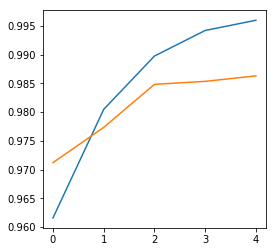

In [0]:
hist = pd.DataFrame(history.history)

plt.figure(figsize=(4,4))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [0]:
t0 = time()
test_pred = model.predict(X_test, verbose=1)
test_time = time() - t0
print("test time:  %0.3fs" % test_time)

373/373 [==============================] - 2s 4ms/step
test time:  1.512s


In [0]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

In [0]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(classification_report(test_labels, pred_labels))

F1-score: 76.3%
           precision    recall  f1-score   support

      LOC       0.83      0.76      0.79       161
      PER       0.80      0.59      0.68       221
      ORG       0.80      0.88      0.84       192
     MISC       0.68      0.75      0.71        67

micro avg       0.79      0.73      0.76       641
macro avg       0.80      0.73      0.76       641



In [0]:
y_test_per = [['PER' if 'PER' in w else 'O' for w in s] for s in test_labels]
y_test_per_acc = [True if 'PER' in s else False for s in y_test_per]

y_pred_per = [['PER' if 'PER' in w else 'O' for w in s] for s in pred_labels]
y_pred_per_acc = [True if 'PER' in s else False for s in y_pred_per]


In [0]:
f1 = f1_score(y_test_per, y_pred_per)
acc = accuracy_score(y_test_per_acc, y_pred_per_acc)
print(f1)
print(acc)

0.6822916666666667
0.9115281501340483


In [0]:
results.append(['Simple_BiLSTMs', f1, acc, train_time, test_time ])

In [0]:
results

[['CRF',
  0.9078014184397163,
  0.9624664879356568,
  35.01606607437134,
  0.06449460983276367],
 ['Simple_BiLSTMs',
  0.6822916666666667,
  0.9115281501340483,
  590.2808156013489,
  1.5124719142913818]]

## b. LSTM-CRF


In [0]:
del input, out
del model, history
gc.collect()
K.clear_session()
tf.reset_default_graph()


In [0]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

In [0]:
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 60, 20)            472520    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 60, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 60, 9)             558       
Total params: 506,528
Trainable params: 506,528
Non-trainable params: 0
_________________________________________________________________


In [0]:
t0 = time()
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)
train_time = time() - t0
print("train time: %0.3fs" % train_time)

Train on 12632 samples, validate on 1404 samples
Epoch 1/5
12632/12632 [==============================] - 203s 16ms/step - loss: 0.1824 - crf_viterbi_accuracy: 0.9466 - val_loss: 0.0999 - val_crf_viterbi_accuracy: 0.9692
Epoch 2/5
12632/12632 [==============================] - 201s 16ms/step - loss: 0.0689 - crf_viterbi_accuracy: 0.9775 - val_loss: 0.0735 - val_crf_viterbi_accuracy: 0.9749
Epoch 3/5
12632/12632 [==============================] - 201s 16ms/step - loss: 0.0404 - crf_viterbi_accuracy: 0.9864 - val_loss: 0.0576 - val_crf_viterbi_accuracy: 0.9803
Epoch 4/5
12632/12632 [==============================] - 200s 16ms/step - loss: 0.0260 - crf_viterbi_accuracy: 0.9912 - val_loss: 0.0495 - val_crf_viterbi_accuracy: 0.9822
Epoch 5/5
12632/12632 [==============================] - 200s 16ms/step - loss: 0.0175 - crf_viterbi_accuracy: 0.9941 - val_loss: 0.0459 - val_crf_viterbi_accuracy: 0.9829
train time: 1008.106s


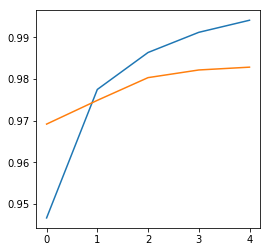

In [0]:
hist = pd.DataFrame(history.history)

plt.figure(figsize=(4,4))
plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])
plt.show()

In [0]:
t0 = time()
test_pred = model.predict(X_test, verbose=1)
test_time = time() - t0
print("test time:  %0.3fs" % test_time)

373/373 [==============================] - 3s 7ms/step
test time:  2.776s


In [ ]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)


In [0]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(classification_report(test_labels, pred_labels))

F1-score: 78.4%
           precision    recall  f1-score   support

      LOC       0.88      0.83      0.85       161
      PER       0.75      0.65      0.70       221
      ORG       0.86      0.86      0.86       192
     MISC       0.68      0.64      0.66        67

micro avg       0.81      0.76      0.78       641
macro avg       0.81      0.76      0.78       641



In [0]:
y_test_per = [['PER' if 'PER' in w else 'O' for w in s] for s in test_labels]
y_test_per_acc = [True if 'PER' in s else False for s in y_test_per]

y_pred_per = [['PER' if 'PER' in w else 'O' for w in s] for s in pred_labels]
y_pred_per_acc = [True if 'PER' in s else False for s in y_pred_per]

f1 = f1_score(y_test_per, y_pred_per)
acc = accuracy_score(y_test_per_acc, y_pred_per_acc)
print(f1)
print(acc)

0.6990291262135923
0.935656836461126


In [0]:
results.append(['LSTM-CRF', f1, acc, train_time, test_time ])

In [0]:
df = pd.DataFrame(results, columns=['Model','f1','acc','train_time','test_time'])

In [0]:
df.to_csv('./results.csv',index=False)

In [0]:
results = pd.read_csv('./results.csv')
results

,Model,f1,acc,train_time,test_time
0,CRF,0.907801,0.962466,35.016066,0.064495
1,Simple_BiLSTMs,0.682292,0.911528,590.280816,1.512472
2,LSTM-CRF,0.699029,0.935657,1008.106285,2.776443


## c. LSTMs With Character Embeddings

In [0]:
!pip uninstall keras
!pip install keras==2.2.5

## reset ipynb 

Uninstalling Keras-2.2.4:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.2.4.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.2.4
  Using cached https://files.pythonhosted.org/packages/f8/ba/2d058dcf1b85b9c212cc58264c98a4a7dd92c989b798823cc5690d062bb2/Keras-2.2.5-py2.py3-none-any.whl


In [0]:
!python -c 'import keras; print(keras.__version__)'

Using TensorFlow backend.
2.2.5


In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from itertools import chain
import gc
from time import time

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
# from sklearn.cross_validation import cross_val_score
# from sklearn.grid_search import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
from keras.utils import to_categorical
from keras_contrib.layers import CRF
from keras import backend as K
import tensorflow as tf

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score

results = []


Using TensorFlow backend.


In [0]:
!python -c 'import keras; print(keras.__version__)'
## needs to be 2.2.5

Using TensorFlow backend.
2.2.5


In [0]:
os.chdir('/gdrive/My Drive/estsoft')

#train_CoNLL03_sample = open('./data/train.txt')
train_CoNLL03_sample = open('./data/train_full.txt')
train = [line for line in train_CoNLL03_sample]

dev_CoNLL03_sample = open('./data/dev.txt')
dev = [line for line in dev_CoNLL03_sample]

import re
def change_form(f):
    form = []
    temp = []
    for line in f:
        if len(line)==0 or line[0]=="\n":
            if len(temp) > 0:
                form.append(temp)
                temp = []
            continue
        feat = line.split(' ')
        feat[-1] = re.sub(r'\n', '', feat[-1])
        temp.append((feat[0],feat[1],feat[3]))
    return form

new_train = change_form(train)
new_dev = change_form(dev)

In [0]:
print(len(new_train))
MAX_SEN_LEN = 60
new_train = [s for s in new_train if (len(s) <= MAX_SEN_LEN)]
print(len(new_train))
print(max(len(sen) for sen in new_train)) 

14041
14036
60


In [0]:
words = set()
tags = set()
max_len_sent = -1
for sent in new_train:
    for w in sent:
        words.add(w[0])
        tags.add(w[2])
    if len(sent) > max_len_sent:
        max_len_sent = len(sent)
words = list(words)
tags = list(tags)

print(max_len_sent)
print(len(words))

words.append("PAD")
words.append("UNK")

n_words = len(words)
n_tags = len(tags)
print(n_words)

60
23574
23576


In [0]:
max_length,longest_element = max([(len(x),x) for x in words])
print(max_length, longest_element)
dev_words = [w[0] for s in new_dev for w in s ]
max_length,longest_element = max([(len(x),x) for x in dev_words])
print(max_length, longest_element)


61 -------------------------------------------------------------
17 Chester-le-Street


In [0]:
[w[0] for s in new_train for w in s  if len(w[0]) >= 28]

['Company-------------Price---Broker----------------',
 'DAY--COMPANY----PERIOD--CONSENSUS----RANGE-------PVS',
 '------------------------------------------------------------',
 '----------------------------------',
 '--------------------------------',
 '-------------------------------------------------------------']

In [0]:
max_len = 60
#max_len_char = 24
max_len_char = 28

words.remove("PAD")
words.remove("UNK")
word2idx = {w: i + 2 for i, w in enumerate(words)}
words.append("PAD")
words.append("UNK")
word2idx["UNK"] = 1
word2idx["PAD"] = 0

idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}


In [0]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0


84


In [0]:
X_tr = [[word2idx[w[0]] for w in s] for s in new_train]

X_te = []
for s in new_dev:
    temp = []
    for w in s:
        if w[0] in word2idx:
            temp.append(word2idx[w[0]])
        else:
            temp.append(word2idx['UNK'])
    X_te.append(temp)

X_train = pad_sequences(maxlen=max_len, sequences=X_tr, value=word2idx["PAD"], 
                       padding='post', truncating='post')
X_test = pad_sequences(maxlen=max_len, sequences=X_te, value=word2idx["PAD"], 
                       padding='post', truncating='post')


In [0]:
def forthe_char(sentences, max_len, max_len_char):
    X_char = []
    for sentence in sentences:
        sent_seq = []
        for i in range(max_len):
            word_seq = []
            for j in range(max_len_char):
                try:
                    word_seq.append(char2idx.get(sentence[i][0][j]))
                except:
                    word_seq.append(char2idx.get("PAD"))
            sent_seq.append(word_seq)
        X_char.append(np.array(sent_seq))
    return X_char

X_char_train = forthe_char(new_train,max_len, max_len_char)
X_char_test = forthe_char(new_dev,max_len, max_len_char)


In [0]:
y_tr = [[tag2idx[w[2]] for w in s] for s in new_train]
y_te = [[tag2idx[w[2]] for w in s] for s in new_dev]

# y_train = pad_sequences(maxlen=max_len, sequences=y_tr, padding="post", value=tag2idx["O"])
# y_test = pad_sequences(maxlen=max_len, sequences=y_te, padding="post", value=tag2idx["O"])

y_train = pad_sequences(maxlen=max_len, sequences=y_tr, value=tag2idx["PAD"],
                  padding='post', truncating='post')
y_test = pad_sequences(maxlen=max_len, sequences=y_te, value=tag2idx["PAD"],
                  padding='post', truncating='post')


In [0]:
# del input, out, model
# del model, history, out
# del word_in, emb_word, char_enc, x, main_lstm, out
gc.collect()
K.clear_session()
tf.reset_default_graph()


In [0]:
# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)
# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_lstm)
model = Model([word_in, char_in], out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 60, 28)       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 60, 28, 10)   860         input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 60, 20)       471560      input_1[0][0]                    
____________________________________________________________________________________________

In [0]:
# history = model.fit([X_train,
#                      np.array(X_char_train).reshape((len(X_char_train), max_len, max_len_char))],
#                     np.array(y_train).reshape(len(y_train), max_len, 1),
#                     batch_size=32, epochs=10, validation_split=0.1, verbose=1)
t0 = time()
history = model.fit([X_train,
                     np.array(X_char_train).reshape((len(X_char_train), max_len, max_len_char))],
                    np.array(y_train).reshape(len(y_train), max_len, 1),
                    batch_size=32, epochs=5, validation_split=0.1, verbose=1)
train_time = time() - t0
print("train time: %0.3fs" % train_time)

Train on 12632 samples, validate on 1404 samples
Epoch 1/5
12632/12632 [==============================] - 203s 16ms/step - loss: 0.7503 - acc: 0.8292 - val_loss: 0.3634 - val_acc: 0.8929
Epoch 2/5
12632/12632 [==============================] - 200s 16ms/step - loss: 0.2953 - acc: 0.9014 - val_loss: 0.2219 - val_acc: 0.9216
Epoch 3/5
12632/12632 [==============================] - 198s 16ms/step - loss: 0.1923 - acc: 0.9359 - val_loss: 0.1982 - val_acc: 0.9388
Epoch 4/5
12632/12632 [==============================] - 198s 16ms/step - loss: 0.1328 - acc: 0.9603 - val_loss: 0.1679 - val_acc: 0.9531
Epoch 5/5
12632/12632 [==============================] - 199s 16ms/step - loss: 0.0880 - acc: 0.9761 - val_loss: 0.1507 - val_acc: 0.9599
train time: 1000.874s


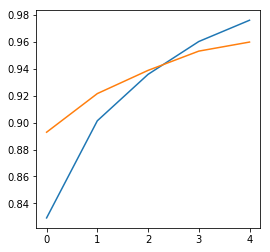

In [0]:
hist = pd.DataFrame(history.history)

plt.figure(figsize=(4,4))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [0]:
t0 = time()
y_pred = model.predict([X_test, np.array(X_char_test).reshape((len(X_char_test),
                                                     max_len, max_len_char))])
test_time = time() - t0
print("test time:  %0.3fs" % test_time)


test time:  2.313s


In [0]:
y_test[2]

array([3, 8, 4, 7, 6, 4, 4, 4, 4, 4, 4, 4, 1, 4, 1, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [0]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(y_pred)
#test_labels = pred2label(y_test) # char embedding에선 y_test는 to_categorical 적용안됨

In [0]:
idx2tag

{0: 'PAD',
 1: 'B-ORG',
 2: 'I-LOC',
 3: 'B-MISC',
 4: 'O',
 5: 'I-ORG',
 6: 'I-PER',
 7: 'B-PER',
 8: 'I-MISC',
 9: 'B-LOC'}

In [0]:
# idx2tag could change
test_labels = [[idx2tag[w] if w != 0 else idx2tag[4]  for w in s] for s in y_test ]

In [0]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(classification_report(test_labels, pred_labels))

F1-score: 43.0%
           precision    recall  f1-score   support

     MISC       0.21      0.42      0.28        67
      ORG       0.83      0.89      0.86       192
      LOC       0.12      0.82      0.21       161
      PER       0.56      0.89      0.68       221

micro avg       0.29      0.82      0.43       641
macro avg       0.49      0.82      0.57       641



In [0]:
y_test_per = [['PER' if 'PER' in w else 'O' for w in s] for s in test_labels]
y_test_per_acc = [True if 'PER' in s else False for s in y_test_per]

y_pred_per = [['PER' if 'PER' in w else 'O' for w in s] for s in pred_labels]
y_pred_per_acc = [True if 'PER' in s else False for s in y_pred_per]

f1 = f1_score(y_test_per, y_pred_per)
acc = accuracy_score(y_test_per_acc, y_pred_per_acc)
print(f1)
print(acc)


0.8100208768267223
0.9249329758713136


In [0]:
print(pred_labels[0][:12])
print(y_test_per[0][:12])
new_dev[0]

['O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


[('CRICKET', 'NNP', 'O'),
 ('-', ':', 'O'),
 ('LEICESTERSHIRE', 'NNP', 'B-ORG'),
 ('TAKE', 'NNP', 'O'),
 ('OVER', 'IN', 'O'),
 ('AT', 'NNP', 'O'),
 ('TOP', 'NNP', 'O'),
 ('AFTER', 'NNP', 'O'),
 ('INNINGS', 'NNP', 'O'),
 ('VICTORY', 'NN', 'O'),
 ('.', '.', 'O')]

In [0]:
print(2 * ((0.56  *  0.89 ) / (0.56  +  0.89 ) ))
print(recall_score(y_test_per, y_pred_per))
print(precision_score(y_test_per, y_pred_per))

0.687448275862069
0.8778280542986425
0.751937984496124


In [0]:
results = pd.read_csv('./results.csv')
results = results.append({'Model':'Char_Embedding', 
                          'f1':f1 , 
                          'acc': acc , 
                          'train_time': train_time , 
                          'test_time': test_time},
                          ignore_index=True)
results.to_csv('./results.csv', index=False)

In [0]:
results

,Model,f1,acc,train_time,test_time
0,CRF,0.907801,0.962466,35.016066,0.064495
1,Simple_BiLSTMs,0.682292,0.911528,590.280816,1.512472
2,LSTM-CRF,0.699029,0.935657,1008.106285,2.776443
3,Char_Embedding,0.810021,0.924933,1000.873730,2.313342


## d. Residual LSTMs And ELMO

In [0]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from itertools import chain
import gc
from time import time

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
# from sklearn.cross_validation import cross_val_score
# from sklearn.grid_search import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
from keras.utils import to_categorical
from keras_contrib.layers import CRF
from keras import backend as K
import tensorflow as tf

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score


In [0]:
os.chdir('/gdrive/My Drive/estsoft')

#train_CoNLL03_sample = open('./data/train.txt')
train_CoNLL03_sample = open('./data/train_full.txt')
train = [line for line in train_CoNLL03_sample]

dev_CoNLL03_sample = open('./data/dev.txt')
dev = [line for line in dev_CoNLL03_sample]

def change_form(f):
    form = []
    temp = []
    for line in f:
        if len(line)==0 or line[0]=="\n":
            if len(temp) > 0:
                form.append(temp)
                temp = []
            continue
        feat = line.split(' ')
        feat[-1] = re.sub(r'\n', '', feat[-1])
        temp.append((feat[0],feat[1],feat[3]))
    return form

new_train = change_form(train)
new_dev = change_form(dev)

In [0]:
print(len(new_train))
MAX_SEN_LEN = 60
new_train = [s for s in new_train if (len(s) <= MAX_SEN_LEN)]
print(len(new_train))
print(max(len(sen) for sen in new_train)) 

14041
14036
60


In [0]:
max_len_dev = -1
for sent in new_dev:
    if len(sent) > max_len_dev:
        max_len_dev = len(sent)
print(max_len_dev)

words = set()
tags = set()
max_len_sent = -1
for sent in new_train:
    for w in sent:
        words.add(w[0])
        tags.add(w[2])
    if len(sent) > max_len_sent:
        max_len_sent = len(sent)
words = list(words)
tags = list(tags)
print(max_len_sent)
n_words = len(words)
n_tags = len(tags)
print(n_words)

max_len = 60
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

46
60
23574


In [0]:
X_tr = [[w[0] for w in s] for s in new_train]
X_te = [[w[0] for w in s] for s in new_dev]
max_len = 60
tag2idx = {t: i for i, t in enumerate(tags)}
def pad_4ELMO(X):
    new_X = []
    for seq in X:
        new_seq = []
        for i in range(max_len):
            try:
                new_seq.append(seq[i])
            except:
                new_seq.append("__PAD__")
        new_X.append(new_seq)
    return new_X
    
X_train = pad_4ELMO(X_tr)
X_test = pad_4ELMO(X_te)

In [0]:
# import tensorflow_hub as hub
# from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
# from keras.layers.merge import add

import tensorflow_hub as hub
from keras.layers import Lambda
from keras.layers.merge import add


In [0]:
sess = tf.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]


In [0]:
y_tr = [[tag2idx[w[2]] for w in s] for s in new_train]
y_te = [[tag2idx[w[2]] for w in s] for s in new_dev]
y_train = pad_sequences(maxlen=max_len, sequences=y_tr, padding="post", value=tag2idx["O"])
y_test = pad_sequences(maxlen=max_len, sequences=y_te, padding="post", value=tag2idx["O"])

In [0]:

#embedding = Lambda(ElmoEmbedding, output_shape=(None, max_len, 1024))(input_text)

# batch_size = 32
batch_size = 35
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 60, 1024)     0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 60, 1024)     6295552     lambda_1[0][0]                   
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 60, 1024)     6295552     bidirectional_1[0][0]            
____________________________________________________________________________________________

In [0]:
len(X_train)

14000

In [0]:
X_train = X_train[:-36]
y_train = y_train[:-36]

In [0]:
from sklearn.model_selection import train_test_split
# X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
# y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2019)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)


In [0]:
t0 = time()
history = model.fit(np.array(X_train), y_train, validation_data=(np.array(X_val), y_val),
                    batch_size=batch_size, epochs=5, verbose=1)
train_time = time() - t0
print("train time: %0.3fs" % train_time)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 12600 samples, validate on 1400 samples
Epoch 1/5
12600/12600 [==============================] - 517s 41ms/step - loss: 0.0431 - acc: 0.9882 - val_loss: 0.0164 - val_acc: 0.9952
Epoch 2/5
12600/12600 [==============================] - 511s 41ms/step - loss: 0.0111 - acc: 0.9967 - val_loss: 0.0127 - val_acc: 0.9963
Epoch 3/5
12600/12600 [==============================] - 512s 41ms/step - loss: 0.0073 - acc: 0.9978 - val_loss: 0.0137 - val_acc: 0.9962
Epoch 4/5
12600/12600 [==============================] - 512s 41ms/step - loss: 0.0047 - acc: 0.9986 - val_loss: 0.0120 - val_acc: 0.9969
Epoch 5/5
12600/12600 [==============================] - 512s 41ms/step - loss: 0.0032 - acc: 0.9990 - val_loss: 0.0116 - val_acc: 0.9973
train time: 2566.434s


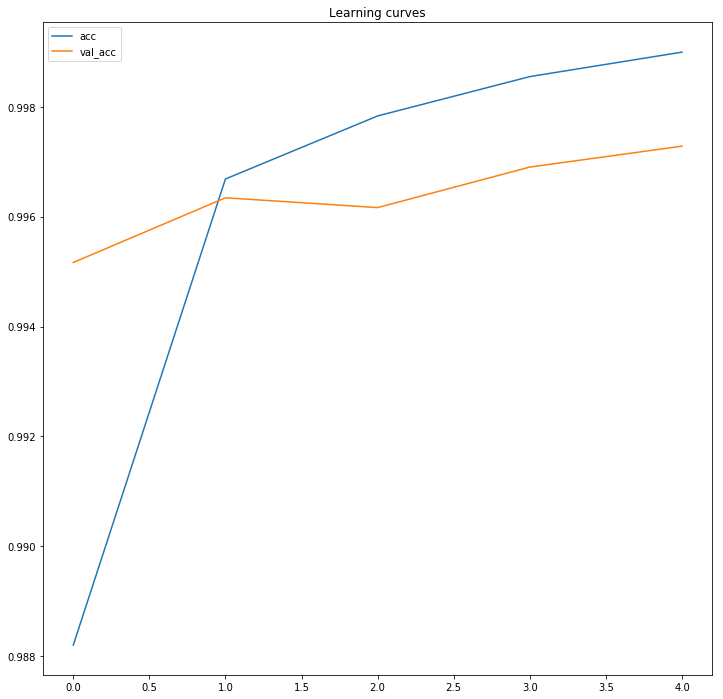

In [0]:
hist = pd.DataFrame(history.history)
plt.figure(figsize=(6,6))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.title("Learning curves")
plt.legend()
plt.show()

In [0]:
from copy import deepcopy
temp_test = deepcopy(X_test)

In [0]:
len(X_test)

373

In [0]:
temp_test_a = temp_test + temp_test[:12] 

In [0]:
len(temp_test_a)

385

In [0]:
t0 = time()
p = model.predict(np.array(temp_test_a), batch_size=batch_size, verbose=1)
test_time = time() - t0
print("test time:  %0.3fs" % test_time)

#p = np.argmax(p, axis=-1)

385/385 [==============================] - 10s 27ms/step
test time:  10.346s


In [0]:
pred = p[:-12]
print(len(pred))

373


In [0]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(pred)
#test_labels = pred2label(y_test)


In [0]:
idx2tag

{0: 'I-LOC',
 1: 'B-LOC',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-MISC',
 5: 'B-PER',
 6: 'I-ORG',
 7: 'B-MISC',
 8: 'O'}

In [0]:
y_test[0]

array([8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], dtype=int32)

In [0]:
# idx2tag could change
test_labels = [[idx2tag[w] for w in s] for s in y_test ]

In [0]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(classification_report(test_labels, pred_labels))

F1-score: 95.2%
           precision    recall  f1-score   support

     MISC       0.89      0.93      0.91        67
      PER       0.98      0.97      0.98       221
      ORG       0.95      0.94      0.94       192
      LOC       0.94      0.96      0.95       161

micro avg       0.95      0.95      0.95       641
macro avg       0.95      0.95      0.95       641



In [0]:
y_test_per = [['PER' if 'PER' in w else 'O' for w in s] for s in test_labels]
y_test_per_acc = [True if 'PER' in s else False for s in y_test_per]

y_pred_per = [['PER' if 'PER' in w else 'O' for w in s] for s in pred_labels]
y_pred_per_acc = [True if 'PER' in s else False for s in y_pred_per]

f1 = f1_score(y_test_per, y_pred_per)
acc = accuracy_score(y_test_per_acc, y_pred_per_acc)
print(f1)
print(acc)


0.9750566893424037
0.9839142091152815


In [0]:
results = pd.read_csv('./results.csv')
results = results.append({'Model':'ELMO_residual', 
                          'f1':f1 , 
                          'acc': acc , 
                          'train_time': train_time , 
                          'test_time': test_time},
                          ignore_index=True)
#results.to_csv('./results.csv', index=False)
results

,Model,f1,acc,train_time,test_time
0,CRF,0.907801,0.962466,35.016066,0.064495
1,Simple_BiLSTMs,0.682292,0.911528,590.280816,1.512472
2,LSTM-CRF,0.699029,0.935657,1008.106285,2.776443
3,Char_Embedding,0.810021,0.924933,1000.873730,2.313342
4,ELMO_residual,0.975057,0.983914,2566.433501,10.346242


In [0]:
results.to_csv('./results.csv', index=False)

## e. BERT

In [0]:
!pip install pytorch_transformers 

In [0]:
import torch
import os
from tqdm import tqdm,trange
import re

from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import BertForTokenClassification, AdamW



Using TensorFlow backend.


In [0]:
os.chdir('/gdrive/My Drive/estsoft')

#train_CoNLL03_sample = open('./data/train.txt')
train_CoNLL03_sample = open('./data/train_full.txt')
train = [line for line in train_CoNLL03_sample]

dev_CoNLL03_sample = open('./data/dev.txt')
dev = [line for line in dev_CoNLL03_sample]

def change_form(f):
    form = []
    temp = []
    for line in f:
        if len(line)==0 or line[0]=="\n":
            if len(temp) > 0:
                form.append(temp)
                temp = []
            continue
        feat = line.split(' ')
        feat[-1] = re.sub(r'\n', '', feat[-1])
        temp.append((feat[0],feat[1],feat[3]))
    return form

new_train = change_form(train)
new_dev = change_form(dev)



In [0]:
print(len(new_train))
MAX_SEN_LEN = 60
new_train = [s for s in new_train if (len(s) <= MAX_SEN_LEN)]
print(len(new_train))
print(max(len(sen) for sen in new_train)) 

14041
14036
60


In [0]:

tr_sentences = [[s[0] for s in sent] for sent in new_train]
dev_sentences = [[s[0] for s in sent] for sent in new_dev]
print(tr_sentences[0])

tr_poses = [[s[1] for s in sent] for sent in new_train]
dev_poses = [[s[1] for s in sent] for sent in new_dev]

tr_labels = [[s[2] for s in sent] for sent in new_train]
dev_labels = [[s[2] for s in sent] for sent in new_dev]


['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']


In [0]:
max_len_dev = -1
for sent in new_dev:
    if len(sent) > max_len_dev:
        max_len_dev = len(sent)
print(max_len_dev)

words = set()
tags = set()
max_len_sent = -1
for sent in new_train:
    for w in sent:
        words.add(w[0])
        tags.add(w[2])
    if len(sent) > max_len_sent:
        max_len_sent = len(sent)
words = list(words)
tags = list(tags)
print(max_len_sent)
n_words = len(words)
n_tags = len(tags)
print(n_words)

max_len = 60
word2idx = {w: i for i, w in enumerate(words)}
# tag2idx = {t: i for i, t in enumerate(tags)}

46
60
23574


In [0]:
# 추가
from copy import deepcopy
tags_vals = deepcopy(tags)
tag2idx = {t: i+3 for i, t in enumerate(tags_vals)}
print(tag2idx)
tag2idx['[CLS]'] = 0
tag2idx['[SEP]'] = 1
tag2idx['X'] = 2

tag2name={tag2idx[key] : key for key in tag2idx.keys()}

{'B-MISC': 3, 'B-LOC': 4, 'O': 5, 'I-LOC': 6, 'B-ORG': 7, 'I-MISC': 8, 'B-PER': 9, 'I-PER': 10, 'I-ORG': 11}


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [0]:
def for_tt_wpl(sentences,labels):
    tokenized_texts = []
    word_piece_labels = []
    i_inc = 0
    for word_list,label in (zip(sentences,labels)):
        temp_lable = []
        temp_token = []
        
        # Add [CLS] at the front 
        temp_lable.append('[CLS]')
        temp_token.append('[CLS]')
        
        for word,lab in zip(word_list,label):
            token_list = tokenizer.tokenize(word)
            for m,token in enumerate(token_list):
                temp_token.append(token)
                if m==0:
                    temp_lable.append(lab)
                else:
                    temp_lable.append('X')  
                    
        # Add [SEP] at the end
        temp_lable.append('[SEP]')
        temp_token.append('[SEP]')
        
        tokenized_texts.append(temp_token)
        word_piece_labels.append(temp_lable)
        
        if 2 > i_inc:
            print("No.%d,len:%d"%(i_inc,len(temp_token)))
            print("texts:%s"%(" ".join(temp_token)))
            print("No.%d,len:%d"%(i_inc,len(temp_lable)))
            print("lables:%s"%(" ".join(temp_lable)))
        i_inc +=1
    return tokenized_texts, word_piece_labels

In [0]:
tr_tokenized_texts , tr_word_piece_labels = for_tt_wpl(tr_sentences, tr_labels)
print()
print("="*80)
print()
dev_tokenized_texts , dev_word_piece_labels = for_tt_wpl(dev_sentences, dev_labels)

No.0,len:12
texts:[CLS] EU rejects German call to boycott British la ##mb . [SEP]
No.0,len:12
lables:[CLS] B-ORG O B-MISC O O O B-MISC O X O [SEP]
No.1,len:4
texts:[CLS] Peter Blackburn [SEP]
No.1,len:4
lables:[CLS] B-PER I-PER [SEP]


No.0,len:37
texts:[CLS] CR ##IC ##KE ##T - L ##EI ##CE ##ST ##ER ##S ##H ##IR ##E T ##A ##KE O ##VE ##R AT TO ##P A ##FT ##ER IN ##NI ##NG ##S VI ##CT ##OR ##Y . [SEP]
No.0,len:37
lables:[CLS] O X X X O B-ORG X X X X X X X X O X X O X X O O X O X X O X X X O X X X O [SEP]
No.1,len:11
texts:[CLS] L ##ON ##D ##ON 1996 - 08 - 30 [SEP]
No.1,len:11
lables:[CLS] B-LOC X X X O X X X X [SEP]


In [0]:
tr_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tr_tokenized_texts],
                          maxlen=max_len, dtype="long", truncating="post", padding="post")
dev_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in dev_tokenized_texts],
                          maxlen=max_len, dtype="long", truncating="post", padding="post")

tr_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in tr_word_piece_labels],
                     maxlen=max_len, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")
dev_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in dev_word_piece_labels],
                     maxlen=max_len, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")

tr_attention_masks = [[int(i>0) for i in ii] for ii in tr_input_ids]
dev_attention_masks = [[int(i>0) for i in ii] for ii in dev_input_ids]

tr_segment_ids = [[0] * len(input_id) for input_id in tr_input_ids]
dev_segment_ids = [[0] * len(input_id) for input_id in dev_input_ids]


train_inputs, val_inputs, train_tags, val_tags,train_masks, val_masks,train_segs, val_segs = \
train_test_split(tr_input_ids, tr_tags, tr_attention_masks, tr_segment_ids, random_state=2019, test_size=0.1)

In [0]:
len(train_inputs),len(val_inputs),len(train_segs),len(val_segs)

(12632, 1404, 12632, 1404)

In [0]:
train_inputs = torch.tensor(train_inputs)
val_inputs = torch.tensor(val_inputs)

train_tags = torch.tensor(train_tags)
val_tags = torch.tensor(val_tags)

train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

train_segs = torch.tensor(train_segs)
val_segs = torch.tensor(val_segs)

In [0]:
# Only set token embedding, attention embedding, no segment embedding
batch_num = 32
train_data = TensorDataset(train_inputs, train_masks, train_tags)
train_sampler = RandomSampler(train_data)
# Drop last can make batch training better for the last one
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_num,drop_last=True)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_num)

In [0]:
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(tag2idx))

In [0]:
model;
model.cuda();

In [0]:
# Set epoch and grad max num
import math
epochs = 5
max_grad_norm = 1.0
num_train_optimization_steps = int( math.ceil(len(train_inputs) / batch_num) / 1) * epochs

In [0]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    # Fine tune model all layer parameters
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    # Only fine tune classifier parameters
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

In [0]:
# TRAIN loop
model.train();

In [0]:
from time import time

In [0]:
print("***** Running training *****")
print("  Num examples = %d"%(len(train_inputs)))
print("  Batch size = %d"%(batch_num))
print("  Num steps = %d"%(num_train_optimization_steps))

t0 = time()

for _ in trange(epochs,desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        # forward pass
        outputs = model(b_input_ids, token_type_ids=None,
        attention_mask=b_input_mask, labels=b_labels)
        loss, scores = outputs[:2]
        if n_gpu>1:
            # When multi gpu, average it
            loss = loss.mean()
        
        # backward pass
        loss.backward()
        
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        
        # update parameters
        optimizer.step()
        optimizer.zero_grad()
        
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))

test_time = time() - t0
print("test time:  %0.3fs" % test_time) # 오타

train_time = time() - t0
print("test time:  %0.3fs" % train_time) # 오타


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 12632
  Batch size = 32
  Num steps = 1975


Epoch:  20%|██        | 1/5 [04:39<18:39, 279.84s/it]

Train loss: 0.5723096344071597


Epoch:  40%|████      | 2/5 [09:19<13:59, 279.89s/it]

Train loss: 0.24828286966318405


Epoch:  60%|██████    | 3/5 [13:59<09:19, 279.92s/it]

Train loss: 0.1395082357835951


Epoch:  80%|████████  | 4/5 [18:39<04:39, 279.95s/it]

Train loss: 0.08584268826064724


Epoch: 100%|██████████| 5/5 [23:19<00:00, 279.98s/it]

Train loss: 0.05381848574686928
test time:  1399.907s


In [0]:
train_time = 1399.907

In [0]:
!dir models

In [0]:
bert_out_address = 'models/'
model_to_save = model.module if hasattr(model, 'module') else model
output_model_file = os.path.join(bert_out_address, "pytorch_model.bin")
output_config_file = os.path.join(bert_out_address, "config.json")
torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(bert_out_address)

('models/vocab.txt',)

In [0]:
tag2idx

{'B-LOC': 9,
 'B-MISC': 11,
 'B-ORG': 6,
 'B-PER': 5,
 'I-LOC': 8,
 'I-MISC': 7,
 'I-ORG': 10,
 'I-PER': 3,
 'O': 4,
 'X': 2,
 '[CLS]': 0,
 '[SEP]': 1}

In [0]:
model = BertForTokenClassification.from_pretrained(bert_out_address,num_labels=len(tag2idx))
model.cuda();


In [0]:
import torch.nn.functional as F

In [0]:
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
y_true = []
y_pred = []

print("***** Running evaluation *****")
print("  Num examples ={}".format(len(val_inputs)))
print("  Batch size = {}".format(batch_num))

t0 = time()

for step, batch in enumerate(valid_dataloader):
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, label_ids = batch
    
#     if step > 2:
#         break
    
    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None,
        attention_mask=input_mask,)
        # For eval mode, the first result of outputs is logits
        logits = outputs[0] 
    
    # Get NER predict result
    logits = torch.argmax(F.log_softmax(logits,dim=2),dim=2)
    logits = logits.detach().cpu().numpy()
    
    
    # Get NER true result
    label_ids = label_ids.to('cpu').numpy()
    
    # Only predict the real word, mark=0, will not calculate
    input_mask = input_mask.to('cpu').numpy()
    
    # Compare the valuable predict result
    for i,mask in enumerate(input_mask):
        # Real one
        temp_1 = []
        # Predict one
        temp_2 = []
        
        for j, m in enumerate(mask):
            # Mark=0, meaning its a pad word, dont compare
            if m:
                if tag2name[label_ids[i][j]] != "X" and tag2name[label_ids[i][j]] != "[CLS]" and tag2name[label_ids[i][j]] != "[SEP]" : # Exclude the X label
                    temp_1.append(tag2name[label_ids[i][j]])
                    temp_2.append(tag2name[logits[i][j]])
            else:
                break
        y_true.append(temp_1)
        y_pred.append(temp_2)


# test time for final validation

***** Running evaluation *****
  Num examples =1404
  Batch size = 32
test time:  10.081s


In [0]:
from seqeval.metrics import f1_score
from seqeval.metrics import classification_report,accuracy_score,f1_score
print("final valid Acc: %f"%(accuracy_score(y_true, y_pred)))

final valid Acc: 0.962138


In [0]:
dev_input_ids, dev_tags, dev_attention_masks, dev_segment_ids

In [0]:
test_inputs = torch.tensor(dev_input_ids)
test_tags = torch.tensor(dev_tags)
test_masks = torch.tensor(dev_attention_masks)
test_segs = torch.tensor(dev_segment_ids)

In [0]:
test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_num)

In [0]:

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
y_true = []
y_pred = []

print("***** Running evaluation *****")
print("  Num examples ={}".format(len(test_inputs)))
print("  Batch size = {}".format(batch_num))

t0 = time()

for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, label_ids = batch
    
#     if step > 2:
#         break
    
    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None,
        attention_mask=input_mask,)
        # For eval mode, the first result of outputs is logits
        logits = outputs[0] 
    
    # Get NER predict result
    logits = torch.argmax(F.log_softmax(logits,dim=2),dim=2)
    logits = logits.detach().cpu().numpy()
    
    
    # Get NER true result
    label_ids = label_ids.to('cpu').numpy()
    
    # Only predict the real word, mark=0, will not calculate
    input_mask = input_mask.to('cpu').numpy()
    
    # Compare the valuable predict result
    for i,mask in enumerate(input_mask):
        # Real one
        temp_1 = []
        # Predict one
        temp_2 = []
        
        for j, m in enumerate(mask):
            # Mark=0, meaning its a pad word, dont compare
            if m:
                if tag2name[label_ids[i][j]] != "X" and tag2name[label_ids[i][j]] != "[CLS]" and tag2name[label_ids[i][j]] != "[SEP]" : # Exclude the X label
                    temp_1.append(tag2name[label_ids[i][j]])
                    temp_2.append(tag2name[logits[i][j]])
            else:
                break
        y_true.append(temp_1)
        y_pred.append(temp_2)

test_time = time() - t0
print("test time:  %0.3fs" % test_time)

***** Running evaluation *****
  Num examples =373
  Batch size = 32
test time:  2.839s


In [0]:
print("F1-score: {:.1%}".format(f1_score(y_true, y_pred)))
print(classification_report(y_true, y_pred))

F1-score: 77.7%
           precision    recall  f1-score   support

      LOC       0.82      0.91      0.86       161
     MISC       0.65      0.76      0.70        67
      PER       0.83      0.75      0.79       221
      ORG       0.79      0.78      0.79       192

micro avg       0.76      0.80      0.78       641
macro avg       0.79      0.80      0.80       641



In [0]:
y_test_per = [['PER' if 'PER' in w else 'O' for w in s] for s in y_true]
y_test_per_acc = [True if 'PER' in s else False for s in y_test_per]

y_pred_per = [['PER' if 'PER' in w else 'O' for w in s] for s in y_pred]
y_pred_per_acc = [True if 'PER' in s else False for s in y_pred_per]

f1 = f1_score(y_test_per, y_pred_per)
acc = accuracy_score(y_test_per_acc, y_pred_per_acc)

print(f1)
print(acc)

0.7838479809976248
0.9142091152815014


In [0]:
import pandas as pd
results = pd.read_csv('./results.csv')
results = results.append({'Model':'BERT_clf', 
                          'f1':f1 , 
                          'acc': acc , 
                          'train_time': train_time , 
                          'test_time': test_time},
                          ignore_index=True)
#results.to_csv('./results.csv', index=False)
results

,Model,f1,acc,train_time,test_time
0,CRF,0.907801,0.962466,35.016066,0.064495
1,Simple_BiLSTMs,0.682292,0.911528,590.280816,1.512472
2,LSTM-CRF,0.699029,0.935657,1008.106285,2.776443
3,Char_Embedding,0.810021,0.924933,1000.873730,2.313342
4,ELMO_residual,0.975057,0.983914,2566.433501,10.346242
5,BERT_clf,0.783848,0.914209,1399.907000,2.839446


In [0]:
results.to_csv('./results.csv', index=False)

# 3. Visualize Results

In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
os.chdir('/gdrive/My Drive/estsoft')

In [0]:
results = pd.read_csv('./results.csv')
results=results.sort_values('f1', ascending = False)
results

,Model,f1,acc,train_time,test_time
4,ELMO_residual,0.975057,0.983914,2566.433501,10.346242
0,CRF,0.907801,0.962466,35.016066,0.064495
3,Char_Embedding,0.810021,0.924933,1000.873730,2.313342
5,BERT_clf,0.783848,0.914209,1399.907000,2.839446
2,LSTM-CRF,0.699029,0.935657,1008.106285,2.776443
1,Simple_BiLSTMs,0.682292,0.911528,590.280816,1.512472


In [0]:
results = results.values.tolist()

In [0]:
indices = np.arange(len(results))

In [0]:
results = [[x[i] for x in results] for i in range(5)]

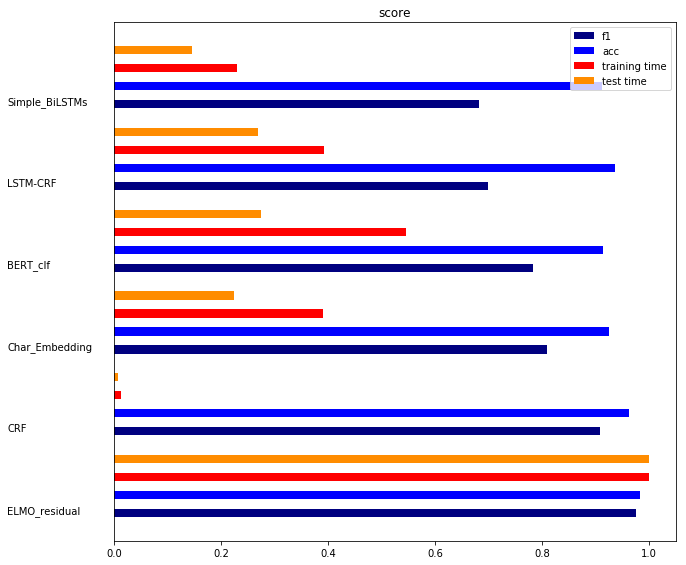

In [0]:
clf_names, f1 , acc, training_time, test_time,  = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("score")

plt.barh(indices, f1, .1, label="f1", color='navy')
plt.barh(indices + .22, acc, .1, label="acc", color='blue')
plt.barh(indices + .44, training_time, .1, label="training time", color='red')
plt.barh(indices + .66, test_time, .1, label="test time", color='darkorange')
plt.yticks(())

plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.2, i, c)

plt.show()

# Spacy & NLTK Tokenizer Issue

- 주어진 데이터를 문장으로 바꾼 후 spacy나 NLTK를 활용해 토큰화 하면 기존의 출력 차원과 달라진다.



In [0]:
import spacy
import nltk
import re
nlp = spacy.load("en_core_web_sm")

In [0]:
train_CoNLL03_sample = open('./data/train.txt')
train = [line for line in train_CoNLL03_sample]

dev_CoNLL03_sample = open('./data/dev.txt')
dev = [line for line in dev_CoNLL03_sample]

In [0]:
def make_sentence(f):
    full_sent = []
    full_ans = []
    temp_sent = ""
    temp_ans = []
    for line in f:
        if len(line)==0 or line[0]=="\n":
            if len(temp_sent) > 0:
                full_sent.append(temp_sent)
                full_ans.append(temp_ans)
                temp_sent = ""
                temp_ans = []
            continue
        token = line.split(' ')
        token[-1] = re.sub(r'\n', '', token[-1])
        if len(temp_sent) == 0 or token[0] == '.':
            temp_sent += token[0] 
        else:
            temp_sent += " "+ token[0]
        temp_ans.append(token[-1])
    return full_sent, full_ans


In [0]:
train_sents, train_ans = make_sentence(train)
dev_sents, dev_ans = make_sentence(dev)

In [0]:
def pos_tag_spacy(sents, anss):
    form = []
    matches = 0
    for i, sent in enumerate(sents):
        temp = []
        doc = nlp(sent)
        if len(doc) == len(anss[i]):
            matches +=1
        for token in doc:
            temp.append((token.text,token.tag_))
        form.append(temp)
        # else:
        #     continue
    print("# of sentence didn't matched:", str(len(sents) - matches))
    return form

In [0]:
train_formed = pos_tag_spacy(train_sents, train_ans)
test_formed = pos_tag_spacy(dev_sents, dev_ans)

# of sentence didn't matched: 411
# of sentence didn't matched: 359


In [0]:
print(train_sents[2])
print(train_formed[2])
print(train_ans[2])

BRUSSELS 1996-08-22
[('BRUSSELS', 'NNP'), ('1996', 'CD'), ('-', 'HYPH'), ('08', 'CD'), ('-', 'HYPH'), ('22', 'CD')]
['B-LOC', 'O']


In [0]:
def pos_tag_nltk(sents, anss):
    form = []
    matches = 0
    for i, sent in enumerate(sents):
        temp = []
        tagged_list = nltk.pos_tag(nltk.word_tokenize(sent))
        if len(tagged_list) == len(anss[i]):
            matches +=1
        form.append(tagged_list)
    print("# of sentence didn't matched:", str(len(sents) - matches))
    return form

In [0]:
train_formed = pos_tag_nltk(train_sents, train_ans)
test_formed = pos_tag_nltk(dev_sents, dev_ans)

# of sentence didn't matched: 119
# of sentence didn't matched: 356


In [0]:
def change_form_spacy(f):
    form = []
    temp_sent = []
    i = 0
    for line in f:
        if len(line) == 0 or line[0]=="\n":
            if len(temp_sent) > 0:
                form.append(temp_sent)
                temp_sent = []
            continue
        token = line.split(' ')
        token[-1] = re.sub(r'\n', '', token[-1])
        doc = nlp(token[0])
        token_POS = doc[0].tag_
        if len(doc) > 1:
            if  i < 30 :
                print(doc)
            i += 1
        temp_sent.append((token[0],token_POS,token[3]))
    print('# of token didnt mathed:' ,str(i))
    return form

In [0]:
train_form = change_form_spacy(train)

1996-08-22
EU-wide
re-examine
brain-wasting
1996-08-22
1996-08-22
1996-08-22
1996-08-22
first-time
year-earlier
Motor-bike
1996-08-22
3311812-4
six-year
1996-08-22
1-10-100
1996-08-22
floating-rate
3M
1-10-100
1996-08-22
Ben-Elissar
right-wing
Israeli-Syrian
1996-08-22
non-payment
1996-08-22
Secretary-General
1996-08-22
One-month
# of token didnt mathed: 539


In [0]:
def change_form_nltk(f):
    form = []
    temp_sent = []
    i = 0
    for line in f:
        if len(line)==0 or line[0]=="\n":
            if len(temp_sent) > 0:
                form.append(temp_sent)
                temp_sent = []
            continue
        token = line.split(' ')
        token[-1] = re.sub(r'\n', '', token[-1])
        tagged_list = nltk.pos_tag(nltk.word_tokenize(token[0]))
        if len(tagged_list) > 1:
            if  i < 30 :
                print(tagged_list)
            i+=1
        temp_sent.append((token[0],tagged_list[0][1],token[3]))
    print('# of token didnt mathed:' ,str(i))
    return form

In [0]:
train_form = change_form_nltk(train)

[('U.S', 'NNP'), ('.', '.')]
[('C', 'NNP'), ('$', '$')]
[('C', 'NNP'), ('$', '$')]
[('S', 'NNP'), ('&', 'CC'), ('P', 'NNP')]
[('S', 'NNP'), ('&', 'CC'), ('P', 'NNP')]
[('U.N', 'NNP'), ('.', '.')]
[('E', 'NN'), ('.', '.')]
[('U.S', 'NNP'), ('.', '.')]
[('D.A', 'NNP'), ('.', '.')]
[('F.C', 'NNP'), ('.', '.')]
[('F.C', 'NNP'), ('.', '.')]
[('F.C', 'NNP'), ('.', '.')]
[('1', 'CD'), ('.', '.')]
[('2', 'CD'), ('.', '.')]
[('3', 'CD'), ('.', '.')]
[('U.S', 'NNP'), ('.', '.')]
[('U.S', 'NNP'), ('.', '.')]
[('U.S', 'NNP'), ('.', '.')]
[('D', 'NNP'), ('.', '.')]
[('S', 'NNP'), ('.', '.')]
[('G', 'NNP'), ('.', '.')]
[('M', 'NNP'), ('.', '.')]
[('J', 'NNP'), ('.', '.')]
[('A', 'DT'), ('.', '.')]
[('A', 'DT'), ('.', '.')]
[('M', 'NNP'), ('.', '.')]
[('D', 'NNP'), ('.', '.')]
[('P', 'NNP'), ('.', '.')]
[('P', 'NNP'), ('.', '.')]
[('N', 'NNP'), ('.', '.')]
# of token didnt mathed: 217


- [Erik F. Tjong Kim Sang, et al. 2003] 에서는 "The English data was tagged and chunked by
the memory-based MBT tagger (Daelemans et al.,
2002). " 라고 했지만 적용 예시를 찾을 수 없었다.

# References

- CRFs:
  - https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html
  - https://github.com/scrapinghub/python-crfsuite/issues/73


- Neural Networks:
  - https://www.depends-on-the-definition.com/guide-sequence-tagging-neural-networks-python/
  - https://github.com/billpku/NLP_In_Action?source=post_page-----936ff275bc73----------------------


- Visualize Results:
  - https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-download-auto-examples-text-plot-document-classification-20newsgroups-py


- Tokenizer Issue:
    - spacy POS-Tagger: https://spacy.io/usage/linguistic-features
    - NLTK POS-Tagger: https://www.nltk.org/book/ch05.html